# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Собираем-сиамскую-сеть" data-toc-modified-id="Собираем-сиамскую-сеть-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Собираем сиамскую сеть</a></div><div class="lev1 toc-item"><a href="#Проверяем-глубокое-представление" data-toc-modified-id="Проверяем-глубокое-представление-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Проверяем глубокое представление</a></div>

In [1]:
import numpy as np
import lasagne
import theano
import theano.tensor as T
from lasagne.nonlinearities import rectify, sigmoid, linear, tanh
from lasagne.layers import InputLayer, DenseLayer, BatchNormLayer, Upscale2DLayer, NonlinearityLayer, ReshapeLayer
from lasagne.layers import Conv2DLayer, MaxPool2DLayer, dropout

import matplotlib.pyplot as plt
%matplotlib inline

import gzip
import pickle

from six.moves import cPickle
from matplotlib import cm
from imutils import face_utils

import os
import cv2
import dlib
from scipy import misc

/home/solo/anaconda3/lib/python3.6/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6021 on context None
Mapped name None to device cuda0: GeForce GTX 980 Ti (0000:02:00.0)


In [2]:
# Seed for reproducibility
np.random.seed(42)

In [3]:
params0 = {'legend.fontsize': 'medium',
          'figure.figsize': (20, 10),
          'agg.path.chunksize' : 0 ,
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'}
plt.rcParams.update(params0)

# Собираем сиамскую сеть

In [4]:
root_dir = './People/lfw2'

def blur(img):
    return cv2.blur(img, (5, 5))


def sharp(img):
    return cv2.filter2D(img, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))


def normalize(x):
    mean = np.mean(x, dtype=np.float64).astype(x.dtype)
    std = np.std(x, dtype=np.float64).astype(x.dtype)
    return (x.astype(np.float_) - mean) / std

def get_samples(path):
    idx_to_name = dict()
    name_to_idx = dict()
    X = list()
    y = list()
    idx = 0
    for l in open(path).readlines()[1:]:
        fields = l.strip().split('\t')
        if len(fields) == 3:
            name, first, second = fields
            if name in name_to_idx:
                cur_idx = name_to_idx[name]
            else:
                name_to_idx[name] = idx
                cur_idx = idx
                idx += 1

            first_photo = os.path.join(root_dir, name, '{}_{:04d}.jpg'.format(name, int(first)))
            second_photo = os.path.join(root_dir, name, '{}_{:04d}.jpg'.format(name, int(second)))
            first_photo_vector = normalize(misc.imread(first_photo))
            second_photo_vector = normalize(misc.imread(second_photo))

            blured_first_photo_vector = blur(first_photo_vector)
            blured_second_photo_vector = blur(second_photo_vector)

            sharped_first_photo_vector = sharp(first_photo_vector)
            sharped_second_photo_vector = sharp(second_photo_vector)
            
            X.append(first_photo_vector)
            y.append(cur_idx)
            X.append(second_photo_vector)
            y.append(cur_idx)

            X.append(blured_first_photo_vector)
            y.append(cur_idx)
            X.append(blured_second_photo_vector)
            y.append(cur_idx)

            X.append(sharped_first_photo_vector)
            y.append(cur_idx)
            X.append(sharped_second_photo_vector)
            y.append(cur_idx)


        elif (fields) == 4:
            first_name, first, second_name, second = fields
            first_photo = os.path.join(root_dir, first_name, '{}_{:04d}.jpg'.format(first_name, first))
            second_photo = os.path.join(root_dir, second_name, '{}_{:04d}.jpg'.format(second_name, second))
            first_photo_vector = normalize(misc.imread(first_photo))
            second_photo_vector = normalize(misc.imread(second_photo))

            blured_first_photo_vector = blur(first_photo_vector)
            blured_second_photo_vector = blur(second_photo_vector)

            sharped_first_photo_vector = sharp(first_photo_vector)
            sharped_second_photo_vector = sharp(second_photo_vector)

            if first_name in name_to_idx:
                cur_idx = name_to_idx[first_name]
            else:
                name_to_idx[first_name] = idx
                cur_idx = idx
                idx += 1
            X.append(first_photo_vector)
            y.append(cur_idx)

            X.append(blured_first_photo_vector)
            y.append(cur_idx)

            X.append(sharped_first_photo_vector)
            y.append(cur_idx)

            if second_name in name_to_idx:
                cur_idx = name_to_idx[second_name]
            else:
                name_to_idx[second_name] = idx
                cur_idx = idx
                idx += 1

            X.append(second_photo_vector)
            y.append(cur_idx)

            X.append(blured_second_photo_vector)
            y.append(cur_idx)

            X.append(sharped_second_photo_vector)
            y.append(cur_idx)

    return np.array(X).reshape([-1, 1, 250, 250]), np.array(y)

X_train, y_train = get_samples('./People/pairsDevTrain.txt')
X_val, y_val = get_samples('./People/pairsDevTest.txt')

    

In [5]:
input_image_left  = T.tensor4('input_left')
input_image_positive = T.tensor4('input_positive')
input_image_negative = T.tensor4('input_negative')

In [6]:
targ_var = T.dvector("target")

In [7]:
l_input = InputLayer(shape=(None, 1, 250, 250), input_var=input_image_left)
p_input = InputLayer(shape=(None, 1, 250, 250), input_var=input_image_positive)
n_input = InputLayer(shape=(None, 1, 250, 250), input_var=input_image_negative)

In [8]:
my_nonlin = rectify
nn_l_conv1 = Conv2DLayer(l_input, 32, (3, 3), nonlinearity=my_nonlin, W=lasagne.init.GlorotUniform())
nn_l_pool1 = MaxPool2DLayer(nn_l_conv1, (2, 2))
nn_l_conv2 = Conv2DLayer(nn_l_pool1, 32, (3, 3), nonlinearity=my_nonlin)
nn_l_pool2 = MaxPool2DLayer(nn_l_conv2, (2, 2))
nn_l_dense = DenseLayer(dropout(nn_l_pool2, p=.5), num_units=256, nonlinearity=my_nonlin)
nn_l_out = DenseLayer(dropout(nn_l_dense, p=.5), num_units=128, nonlinearity=my_nonlin)

In [9]:
l_params = lasagne.layers.get_all_params(nn_l_out)

In [10]:
nn_p_conv1 = Conv2DLayer(p_input, 32, (3, 3), nonlinearity=my_nonlin, W=l_params[0], b=l_params[1])
nn_p_pool1 = MaxPool2DLayer(nn_p_conv1, (2, 2))
nn_p_conv2 = Conv2DLayer(nn_p_pool1, 32, (3, 3), nonlinearity=my_nonlin, W=l_params[2], b=l_params[3])
nn_p_pool2 = MaxPool2DLayer(nn_p_conv2, (2, 2))
nn_p_dense = DenseLayer(dropout(nn_p_pool2, p=0.5), num_units=256, nonlinearity=my_nonlin, W=l_params[4], b=l_params[5])
nn_p_out = DenseLayer(dropout(nn_p_dense, p=0.5), num_units=128, nonlinearity=my_nonlin, W=l_params[6], b=l_params[7])

In [11]:
nn_n_conv1 = Conv2DLayer(n_input, 32, (3, 3), nonlinearity=my_nonlin, W=l_params[0], b=l_params[1])
nn_n_pool1 = MaxPool2DLayer(nn_n_conv1, (2, 2))
nn_n_conv2 = Conv2DLayer(nn_n_pool1, 32, (3, 3), nonlinearity=my_nonlin, W=l_params[2], b=l_params[3])
nn_n_pool2 = MaxPool2DLayer(nn_n_conv2, (2, 2))
nn_n_dense = DenseLayer(dropout(nn_n_pool2, p=0.5), num_units=256, nonlinearity=my_nonlin, W=l_params[4], b=l_params[5])
nn_n_out = DenseLayer(dropout(nn_n_dense, p=0.5), num_units=128, nonlinearity=my_nonlin, W=l_params[6], b=l_params[7])

<b>input</b> - вход

<b>conv</b> - свёртка

<b>pool</b> - слой подвыборки

<b>fully-conn</b> - полносвязный слой

conv1
pool1
rnorm1
conv2a
conv2
rnorm2
pool2
conv3a
conv3
pool3
conv4a
conv4
conv5a
conv5
conv6a
conv6
pool4
concat
fc1
fc2
fc7128
L2

In [12]:
nn_merge = lasagne.layers.concat([nn_l_out, nn_p_out, nn_n_out], axis=1)

In [13]:
nn_out  = lasagne.layers.get_output(nn_merge, deterministic=True)
nn_out_test  = lasagne.layers.get_output(nn_merge, deterministic=True)
nn_out_left = nn_out[:, :128]
nn_out_positive = nn_out[:, 128:256]
nn_out_negative = nn_out[:, 256:]

nn_out_left_test = nn_out_test[:, :128]
nn_out_positive_test = nn_out_test[:, 128:256]
nn_out_negative_test = nn_out_test[:, 256:]

In [14]:
a = T.scalar()

d1 = T.sum(T.sqr(nn_out_left - nn_out_positive), axis=1)
d2 = T.sum(T.sqr(nn_out_left - nn_out_negative), axis=1)

loss = T.sum(T.maximum(T.sqr(d1) - T.sqr(d2) + a, 0.))

In [15]:
d1_test = T.sum(T.sqr(nn_out_left_test - nn_out_positive_test), axis=1)
d2_test = T.sum(T.sqr(nn_out_left_test - nn_out_negative_test), axis=1)
test_loss = T.sum(T.maximum(T.sqr(d1_test) - T.sqr(d2_test) + a, 0.))


# nn_out_right = nn_out[:, 256:]
# nn_out_right_test = nn_out_test[:, 256:]
# margin = 1.2
# d = T.sum(T.sqr(nn_out_left - nn_out_right), axis=1)
# d_test = T.sum(T.sqr(nn_out_left_test - nn_out_right_test), axis=1)
# loss = T.mean(targ_var * T.sqr(d) + (1 - targ_var) * T.sqr(T.maximum(margin - d, 0)))
# mean_accuracy = T.mean(T.eq(targ_var, (d_test < margin)))

In [16]:
params = lasagne.layers.get_all_params(nn_merge)
# updates = lasagne.updates.rmsprop(loss, params)
updates = lasagne.updates.adamax(loss, params)
# updates = lasagne.updates.nesterov_momentum(loss, params, 0.01)

In [17]:
train_fn = theano.function([input_image_left, input_image_positive, input_image_negative, a], loss, 
                           updates=updates, allow_input_downcast=True)
val_fn = theano.function([input_image_left, input_image_positive, input_image_negative, a], test_loss, 
                         updates=updates, allow_input_downcast=True)
test_fn = theano.function([input_image_left, input_image_positive, input_image_negative], [d1_test, d2_test], 
                          allow_input_downcast=True)
output_fn = theano.function([input_image_left, input_image_positive, input_image_negative], nn_out, 
                            allow_input_downcast=True)

In [18]:
def iterate_minibatches(inputs, targets, batchs_per_epoch=100, batchsize=20, train=True, shuffle=False):
    assert len(inputs) == len(targets)

    left_indices = np.arange(len(inputs))
    
    if shuffle:
        np.random.shuffle(left_indices)
        
    for _ in range(batchs_per_epoch):
        full_lft_indxs = []
        full_pos_indxs = []
        full_neg_indxs = []
        
        for _ in range(batchsize):
            start_idx = np.random.randint(low=0, high=len(left_indices))
            full_lft_indxs.append(start_idx)
            
            pos_idxs = np.where(targets == targets[start_idx])[0]
            b_idxs = np.random.randint(low=0, high=len(pos_idxs), size=1)
            full_pos_indxs.append(pos_idxs[b_idxs[0]])
            
            neg_idxs = np.where(targets != targets[start_idx])[0]
            b_idxs = np.random.randint(low=0, high=len(neg_idxs), size=1)
            full_neg_indxs.append(neg_idxs[b_idxs[0]])

        full_lft_indxs = np.array(full_lft_indxs)
        full_pos_indxs = np.array(full_pos_indxs)
        full_neg_indxs = np.array(full_neg_indxs)
        
        yield inputs[full_lft_indxs], inputs[full_pos_indxs], inputs[full_neg_indxs]

In [19]:
num_epochs = 200
train_errors = []
val_errors = []
epoch = 0
batch_size = 50
batchs_per_epoch = 20

margin = 1.242

In [20]:
import time

for epoch in range(epoch, num_epochs):
    
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batchs_per_epoch=batchs_per_epoch,
                                     batchsize=batch_size, train=True, shuffle=True):
        inputs_left, inputs_positive, inputs_negative = batch
        err = train_fn(inputs_left, inputs_positive, inputs_negative, margin)
        train_err += err
        train_batches += 1
    print(err)

    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batchs_per_epoch=batchs_per_epoch,
                                     batchsize=batch_size, train=False, shuffle=True):
        inputs_left, inputs_positive, inputs_negative = batch
        err = val_fn(inputs_left, inputs_positive, inputs_negative, margin)
        val_err += err
        val_batches += 1

    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    train_errors.append(train_err / train_batches)
    val_errors.append(val_err / val_batches)

100.08285522460938
Epoch 1 of 200 took 9.128s
  training loss:		104771.920252
  validation loss:		61.128520
45.3949089050293
Epoch 2 of 200 took 8.703s
  training loss:		88.522592
  validation loss:		54.779235
46.783355712890625
Epoch 3 of 200 took 9.054s
  training loss:		53.102009
  validation loss:		50.487076
43.16396713256836
Epoch 4 of 200 took 8.853s
  training loss:		49.633987
  validation loss:		44.576805
33.48088073730469
Epoch 5 of 200 took 8.754s
  training loss:		47.986729
  validation loss:		40.932904
44.79328918457031
Epoch 6 of 200 took 8.755s
  training loss:		47.545592
  validation loss:		34.237150
30.52853775024414
Epoch 7 of 200 took 8.754s
  training loss:		34.078363
  validation loss:		33.342321
38.113887786865234
Epoch 8 of 200 took 8.753s
  training loss:		35.582907
  validation loss:		27.344811
33.22024154663086
Epoch 9 of 200 took 8.754s
  training loss:		36.284990
  validation loss:		26.385753
38.983734130859375
Epoch 10 of 200 took 8.755s
  training loss:		62

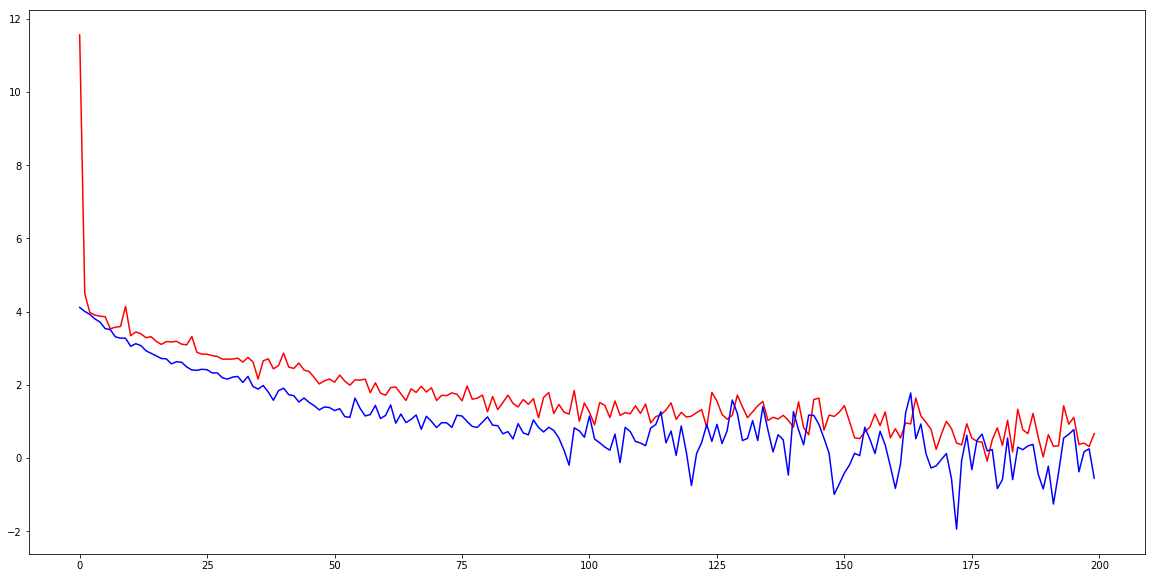

In [21]:
plt.plot(np.log(train_errors), 'r')
plt.plot(np.log(val_errors), 'b')
plt.show()

# Тест загрузки БД лиц группы

In [20]:
shapo = './cascade/shape_predictor_68_face_landmarks.dat'
etector = dlib.get_frontal_face_detector()
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shapo)

frame_size = 250
fa = face_utils.FaceAligner(predictor, desiredFaceHeight=frame_size, 
                            desiredFaceWidth=frame_size)

In [16]:
def download_db(path):
    idx_to_name = dict()
    X = list()
    y = list()
    for i, name in enumerate(os.listdir(path)):
        idx_to_name[i] = name
        human_photo_dir = os.path.join(path, name)
        for photo in os.listdir(human_photo_dir):
            frame = misc.imread(os.path.join(human_photo_dir, photo))
            gray_face = detect_to_gray(frame)
            if gray_face is not None:
                X.append(list(gray_face))
                y.append(i)
    return np.array(X), np.array(y), idx_to_name

In [18]:
def ochorn_points(frame, gray):
    rects = detector(gray, 1)
    for rect in rects:
        # shape = predictor(gray, rect)
        # shape = face_utils.shape_to_np(shape)
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        xc = x + w // 2
        yc = y + h // 2
        faceAligned = fa.align(frame, gray, rect)
        if faceAligned is not None:
            return xc, yc, faceAligned
        else:
            return None

def detect_to_gray(frame, coord=False):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    detected_par = ochorn_points(frame, gray_frame)
    if detected_par is not None:
        xc, yc, faces_d = detected_par
        gray_face = normalize(cv2.cvtColor(faces_d, cv2.COLOR_BGR2GRAY))
        if coord:
            return xc, yc, gray_face
        else:
            return gray_face
    else:
        return None

In [ ]:
# ./People/db - папка, в которой лежат именованные папки с фотографиями
X, y, idx_to_name = download_db('./People/db')
print('People')

In [24]:
X_train, y_train = get_samples('./People/pairsDevTrain.txt')
print('train')

train


In [25]:
X_val, y_val = get_samples('./People/pairsDevTest.txt')
print('val')

val


# Дамп параметров модели

In [22]:
np.savez('model.npz', *lasagne.layers.get_all_param_values(nn_merge))

# Выгрузка дампа

In [5]:
with np.load('model.npz') as f:
param_values = [f['arr_%d' % i] for i in range(len(f.files))]
lasagne.layers.set_all_param_values(nn_merge, param_values)

In [6]:
output_fn

# Проверяем глубокое представление

In [28]:
from sklearn import decomposition

In [29]:
from mpl_toolkits.mplot3d import Axes3D

In [30]:
deep_ids = []

In [30]:
y_val[:12]

array([0, 0, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4])

In [31]:
for i in range(X_val.shape[0]):
    deep_ids.append(output_fn([X_val[i]], [X_val[0]], [X_val[0]])[0])

# Проверка результатов расстояний для обученной модели

In [33]:
for i in range(X_train.shape[0]):
    res = output_fn([X_train[i]], [X_train[1]], [X_train[1]])
    x1 = res[:, :128]
    x2 = res[:, 128:256]
    x3 = res[:, 256:]
    print(y_train[i], ((x1-x3)**2).sum())

0 0.834842
0 0.0
0 0.514175
0 0.54153
1 2.52579
1 1.79327
2 3.27032
2 2.26744
3 1.89855
3 3.71556
3 2.95704
3 2.3304
4 4.87742
4 3.75987
4 3.24574
4 3.75987
5 2.16837
5 2.43695
5 3.49946
5 2.43695
6 3.70003
6 2.5909
6 3.70003
6 3.32987
6 1.98274
6 3.32987
7 3.23616
7 3.32293
8 2.15027
8 2.48736
9 5.89607
9 4.84139
10 3.22957
10 3.51992
11 2.91767
11 3.95772
11 2.82999
11 3.95772
12 6.56791
12 7.39747
13 6.59816
13 6.66465
13 6.59314
13 6.66465
14 1.57845
14 2.05529
15 4.05302
15 3.44519
16 2.71242
16 2.81072
17 2.25308
17 2.58151
18 7.24717
18 7.07028
19 2.15267
19 4.06782
19 2.15267
19 3.55852
19 4.06782
19 3.55815
19 3.55815
19 3.55852
20 1.91882
20 3.38356
21 2.81234
21 3.61319
22 2.68763
22 2.58777
23 2.63492
23 1.74891
23 2.63492
23 3.40483
24 2.07316
24 2.37329
25 2.03971
25 2.00179
26 4.1747
26 4.75179
27 2.64424
27 2.49211
28 0.865487
28 1.53399
29 2.40225
29 3.94404
30 2.31824
30 3.15562
31 3.12809
31 2.83055
31 2.83055
31 2.49905
32 5.92647
32 4.58503
33 1.49162
33 1.14239
34

In [ ]:
res = output_fn([X_val[665]], [X_val[1]], [X_val[1]])
print(res[:, :128])
print(res[:, 128:256])
print(res[:, 256:])
# print(res)

In [ ]:
res = output_fn([X_val[i]], [X_val[0]], [X_val[0]])
x1 = res[:, :128]
x2 = res[:, 128:256]
x3 = res[:, 256:]
print(y_val[i], ((x1-x3)**2).sum())

In [236]:
deep_ids = np.array(deep_ids)

In [201]:
pca = decomposition.PCA(n_components=2)
pca.fit(deep_ids)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [202]:
X_val_vis = pca.transform(deep_ids)

In [203]:
np.save('X_val_vis-2D', arr=X_val_vis)

In [204]:
np.save('y_val_vis', arr=y_val)

In [205]:
X_val_vis

array([[-0.04510951, -0.03137431],
       [-0.04665209, -0.03292156],
       [-0.04510429, -0.03136114],
       ..., 
       [ 0.98236327, -0.05572428],
       [-0.04511087, -0.03139892],
       [ 0.79802195, -0.11110419]])

TypeError: text() missing 1 required positional argument: 's'

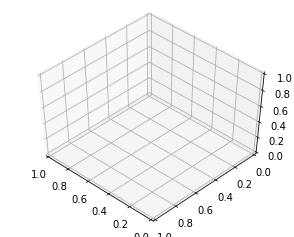

In [208]:
fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

for label in range(10):
    ax.text3D(X_val_vis[y_val == label, 0].mean(),
              X_val_vis[y_val == label, 1].mean(), str(label),
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
    
plt.show()